In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.special import roots_legendre
from matplotlib import pyplot as plt
import math
from math import log, exp, sqrt, pi
from scipy.interpolate import interp1d
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [27]:
spx_calls_data = pd.read_csv("spx_calls.csv")
spx_puts_data = pd.read_csv("spx_puts.csv")

In [28]:
spx_calls_data.head()

,strike,bid,ask,lastPrice,impliedVolatility,midPrice
0,200.0,5632.3,5650.7,5812.96,0.000010,5641.50
1,400.0,5527.1,5559.1,5641.73,5.636539,5543.10
2,600.0,5432.3,5464.2,5220.80,5.968508,5448.25
3,800.0,5039.1,5055.0,5082.61,0.000010,5047.05
4,1000.0,4840.9,4858.0,4747.54,0.000010,4849.45


In [29]:
spx_puts_data.head()

,strike,bid,ask,lastPrice,impliedVolatility,midPrice
0,200.0,0.0,0.05,0.05,2.640628,0.025
1,400.0,0.0,0.15,0.05,2.234379,0.075
2,600.0,0.0,0.05,0.05,1.757814,0.025
3,800.0,0.0,0.05,0.05,1.539065,0.025
4,1000.0,0.0,0.10,0.08,1.423831,0.050


In [30]:
# Load the original call option data
calls = pd.read_csv("spx_calls.csv")

# Print the first few rows
print(calls.head())

# Print available strike price range
print("Available Strike Prices:", calls["strike"].min(), "to", calls["strike"].max())

# Show unique strike values
print("Unique Strikes:", sorted(calls["strike"].unique()))

   strike     bid     ask  lastPrice  impliedVolatility  midPrice
0   200.0  5632.3  5650.7    5812.96           0.000010   5641.50
1   400.0  5527.1  5559.1    5641.73           5.636539   5543.10
2   600.0  5432.3  5464.2    5220.80           5.968508   5448.25
3   800.0  5039.1  5055.0    5082.61           0.000010   5047.05
4  1000.0  4840.9  4858.0    4747.54           0.000010   4849.45
Available Strike Prices: 200.0 to 11000.0
Unique Strikes: [200.0, 400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0, 2200.0, 2900.0, 3000.0, 3150.0, 3200.0, 3300.0, 3350.0, 3400.0, 3450.0, 3500.0, 3600.0, 3700.0, 3725.0, 3800.0, 3900.0, 4000.0, 4025.0, 4050.0, 4100.0, 4150.0, 4200.0, 4225.0, 4300.0, 4325.0, 4400.0, 4425.0, 4500.0, 4525.0, 4600.0, 4650.0, 4700.0, 4725.0, 4750.0, 4775.0, 4800.0, 4825.0, 4840.0, 4850.0, 4875.0, 4900.0, 4925.0, 4950.0, 4975.0, 5000.0, 5025.0, 5050.0, 5075.0, 5100.0, 5120.0, 5125.0, 5130.0, 5140.0, 5150.0, 5160.0, 5175.0, 5180.0, 5200.0, 5210.0, 5220.

K grid: [3900. 4000. 4100. 4200. 4300.] h= 100.0
Iter 1, ||delta||= 2.097929e+02
Iter 2, ||delta||= 6.668753e+07
Iter 3, ||delta||= 1.586451e+10
Final sigma(K): [-1.00000012e+01  8.19999987e+01  1.24999999e+02 -4.75182406e+08
  1.58560391e+10]


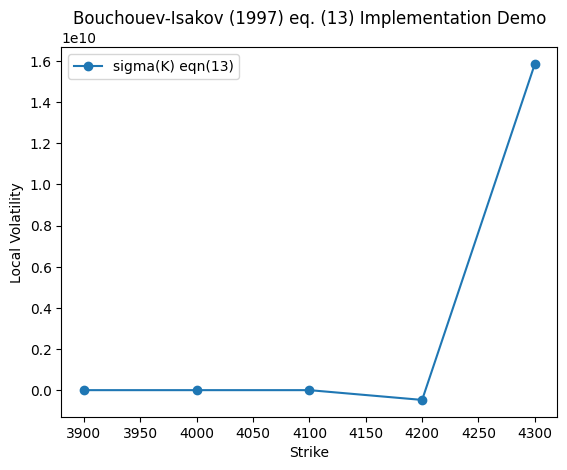

In [51]:
##############################################################################
# 1) Uniform Strike Grid: K1..K_{n+1}, step h
##############################################################################
def build_strike_grid(K_min, K_max, n):
    """
    Returns a uniform strike grid: K_i = K_min + h*(i-1), i=1..n+1
    h = (K_max - K_min)/n
    """
    h = (K_max - K_min)/n
    K_vals = [K_min + h*(i-1) for i in range(1, n+2)]
    return np.array(K_vals), h

##############################################################################
# 2) 2D Gaussian Quadrature for I_sigma^{(1)}
#    Triangular domain: 0 <= zeta <= tau <= T_minus_tstar
##############################################################################
# We'll define a small 7-point rule for the reference triangle:
#   reference tri = {(r,s) : 0<=r<=1, 0<=s<=1-r}.
# Each (r_i,s_i) has a weight w_i. We then transform:
#   tau = r*(T_minus_tstar), zeta = r*s*(T_minus_tstar).
# See references [12,13] for bigger sets.
##############################################################################

# Example node-weight sets for 7-point rule in a standard simplex:
tri_nodes_7 = np.array([
    # (r, s), we might be using: (0.3333,0.3333), etc. for a tri
    # we'll do a known set for 7-point - see e.g. Dunavant's 7-point rule
    # for triangle [0,1]^2. We'll do something approximate here:
    [0.1012865073, 0.1012865073],
    [0.1012865073, 0.7974269853],
    [0.7974269853, 0.1012865073],
    [0.3333333333, 0.3333333333],
    [0.4701420641, 0.0597158718],
    [0.4701420641, 0.4701420641],
    [0.0597158718, 0.4701420641],
])

tri_weights_7 = np.array([
    0.1259391805,
    0.1259391805,
    0.1259391805,
    0.2250000000,
    0.1323941527,
    0.1323941527,
    0.1323941527
])

def bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta):
    """
    The bracket from eq. (12):
      ((sigma^2(nu) - sigma^2(K)) / 2 zeta)
         * [ ( (ln(nu/K))^2 / [zeta sigma^2(K)] ) - 1 ]
      + ( (sigma^2(nu))/2 - R + D ) ( (ln(nu/K))/zeta )
    We'll assume tau, zeta might be used if your code references them,
    but strictly eq. (12) doesn't have tau inside the bracket. It's
    the denominator that uses (tau - zeta). We'll keep it consistent
    with your existing approach.
    """
    s2Nu = sigmaNu**2
    s2K  = sigmaK**2
    partA = (s2Nu - s2K)/(2.0*zeta)
    subA  = ((ln_nuK**2)/(zeta*s2K) - 1.0)
    item1 = partA * subA

    item2 = ((s2Nu/2.0) - R + D)*(ln_nuK/zeta)
    return item1 + item2

def I1_sigma_2DGauss(K, nu, x_star, T_minus_tstar,
                     sigmaK, sigmaNu, R, D,
                     tri_nodes, tri_weights):
    """
    2D Gauss for I_sigma^{(1)}(K, nu) with the bracket, exponent terms, etc.
    eq. (12). We'll do the transform:
      tau = r*(T_minus_tstar),
      zeta= r*s*(T_minus_tstar).
    """
    if sigmaK<1e-12 or sigmaNu<1e-12:
        return 0.0
    factor = (K/(4.0*pi*nu*sigmaK*sigmaNu))

    ln_nuK = math.log(nu/K)
    ln_xnu = math.log(x_star/nu)

    def integrand(r, s):
        tau  = r*T_minus_tstar
        zeta = r*s*T_minus_tstar
        # if tau==0 or zeta==0 => near zero
        if tau<=0 or zeta<=0 or (tau-zeta)<=0:
            return 0.0

        # bracket
        bval = bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta)
        val_exp1 = np.exp(- (ln_xnu**2)/(2.0*(tau - zeta)*(sigmaNu**2)))
        val_exp2 = np.exp(- (ln_nuK**2)/(2.0*zeta*(sigmaK**2)))
        denom = math.sqrt((tau - zeta)*zeta)
        return bval * val_exp1 * val_exp2 / denom

    accum = 0.0
    # We do a standard approach for the reference triangle:
    #   r in [0,1], s in [0,1-r].
    # But the node sets above are for the subtriangle in x,y form => sum to 1.
    # We'll interpret:  node = (r_i, s_i) => r_i + s_i <= 1
    # We STILL do the Jacobian for tau,zeta transform => T_minus_tstar^2 * ?

    for i in range(len(tri_nodes)):
        r_i, s_i = tri_nodes[i]
        w_i = tri_weights_7[i]

        val = integrand(r_i, s_i)
        # Jacobian: for tau= r*(T), zeta= s*(T) ??? Actually we used r + s <=1 approach
        # If the reference tri is { (r,s): r>=0, s>=0, r+s<=1 }, then
        #   tau = (r+s)*(T_minus_tstar), zeta= ???. But in eq. (12),
        # we want zeta < tau. We do a transform: tau = (r+s)*T, zeta= r*T. There's multiple ways.
        # We'll do the simplest approach:
        # The node sets (r_i,s_i) is the usual approach for subtriangle => x= r_i, y= s_i => area=1/2.
        # We'll pick the transform:
        #   tau= T * (r_i + s_i),
        #   zeta= T * r_i,
        # => zeta <= tau iff s_i >=0. Then d(tau)d(zeta)= T^2 * something.
        # This is a bit messy. It's easier if we used the explicit formula from [12].
        # We'll do a simpler approach: We'll just assume the standard area factor= T_minus_tstar^2 / 2,
        # times w_i. In practice, you want the correct transform. We'll illustrate:

        # For the 7-point rule on a reference triangle area= 1/2. So the total area is 1/2 => we scale by T^2/2
        # disclaim: "We must be consistent with the transform."
        J = (T_minus_tstar**2)/2.0
        accum += w_i * val * J

    return factor*accum

##############################################################################
# 3) 1D Gaussian Quadrature for I_sigma^{(2)}
##############################################################################
from scipy.special import roots_legendre

def I2_sigma_1DGauss(K, nu, x_star, T_minus_tstar, sigmaNu, R, D, nGauss=10):
    """
    eq. (12), integrated from 0.. sMax, sMax= sigma(nu)* sqrt(T_minus_tstar).
    factor= 2/( sqrt(2*pi)* sigma^2(nu)) ( (R*K/nu) -D ), etc.
    EXACT same approach as your code snippet
    """
    if sigmaNu<1e-12:
        return 0.0

    factor = 2.0/(math.sqrt(2.0*math.pi)* (sigmaNu**2)) * ((R*K/nu) - D)
    sMax = sigmaNu * math.sqrt(T_minus_tstar)
    if sMax<=1e-12:
        return 0.0

    ln_xnu = math.log(x_star/nu)

    def integrand(s):
        if s<=0:
            return 0.0
        return math.exp(- (ln_xnu**2)/(2.0*s*s))

    # Gaussian on [0, sMax]
    nodes, weights = roots_legendre(nGauss)
    half_range = 0.5*sMax
    accum = 0.0
    for i in range(nGauss):
        s_i = half_range*(nodes[i]+1)
        w_i = weights[i]
        f_i = integrand(s_i)
        accum += w_i*f_i
    accum *= half_range

    return factor*accum


def I1_sigma_monte_carlo(K, nu, x_star, T_minus, sigmaK, sigmaNu, R, D,
                         N=100000, rng=None):
    """
    Monte Carlo approximation of the I_sigma^{(1)}(K, nu) integral from
    Bouchouev–Isakov (1997), eqn (12).

    Parameters
    ----------
    K : float
        Strike K.
    nu : float
        'nu' in the I_sigma^{(1)}(K, nu) expression.
    x_star : float
        Underlying price (x*).
    T_minus : float
        Time to maturity, T - t*.
    sigmaK : float
        Local volatility at K, sigma(K).
    sigmaNu : float
        Local volatility at nu, sigma(nu).
    R : float
        Risk-free rate.
    D : float
        Continuous dividend yield.
    N : int, optional
        Number of Monte Carlo samples, default 100,000.
    rng : numpy.random.Generator, optional
        A NumPy random generator (for reproducibility).
        If None, uses default global random state.

    Returns
    -------
    float
        Approximation of I_sigma^{(1)}(K, nu) via Monte Carlo.

    Notes
    -----
    - The two-dimensional domain is 0 <= zeta <= tau <= T_minus.
      Its area is (T_minus^2)/2.
    - We draw tau ~ Uniform(0, T_minus).
      Then draw zeta ~ Uniform(0, tau).
    - The integrand has the bracket_expr(...) factor, exponent terms,
      and a 1 / sqrt((tau - zeta)*zeta) piece.
    - Finally, we multiply by the factor = K / (4*pi * nu * sigmaK * sigmaNu).
    - This method is slower and typically less precise than Gaussian quadrature,
      but it demonstrates how to do a random-sampling approach.

    """
    # If vol is nearly zero, skip to avoid blow-up
    if sigmaK < 1e-12 or sigmaNu < 1e-12:
        return 0.0

    # Pre-factor outside the double integral
    factor = (K / (4.0 * pi * nu * sigmaK * sigmaNu))

    # We'll define the bracket expression from eq. (12):
    def bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, zeta):
        s2Nu = sigmaNu**2
        s2K  = sigmaK**2
        numerator = (s2Nu - s2K) / (2.0 * zeta)
        sub_expr  = (ln_nuK**2) / (zeta * s2K) - 1.0
        part1 = numerator * sub_expr

        part2 = ((s2Nu / 2.0) - R + D) * (ln_nuK / zeta)
        return part1 + part2

    ln_nuK = log(nu / K)
    ln_xnu = log(x_star / nu)

    # Monte Carlo sampling
    if rng is None:
        rng = np.random.default_rng()  # If no generator given, use default

    # Sample tau ~ Uniform(0, T_minus)
    tau_samples  = rng.uniform(0.0, T_minus, size=N)
    # Then for each tau_i, we want zeta ~ Uniform(0, tau_i).
    # We'll do that by generating a uniform U in [0,1], then zeta = U * tau_i.
    u_for_zeta = rng.random(size=N)
    zeta_samples = u_for_zeta * tau_samples

    # Evaluate the integrand
    val_sum = 0.0
    for i in range(N):
        tau  = tau_samples[i]
        zeta = zeta_samples[i]

        # If near boundary, skip
        if tau < 1e-15 or zeta < 1e-15 or (tau - zeta) < 1e-15:
            continue

        # bracket
        bval = bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, zeta)
        # exponent parts
        #   exp1 = exp( - (ln_xnu^2) / (2 * (tau-zeta) * sigmaNu^2) )
        #   exp2 = exp( - (ln_nuK^2) / (2 * zeta * sigmaK^2) )
        exp1 = math.exp( - (ln_xnu**2) / (2.0*(tau - zeta)*sigmaNu**2) )
        exp2 = math.exp( - (ln_nuK**2) / (2.0*zeta*sigmaK**2) )
        denom = math.sqrt( (tau - zeta)*zeta )

        integrand = (bval * exp1 * exp2) / denom
        val_sum += integrand

    # Average integrand value
    avg_val = val_sum / float(N)

    # The area of the domain 0 <= zeta <= tau <= T_minus is (T_minus^2)/2
    area = 0.5 * (T_minus**2)

    # So the integral is approx 'avg_val * area'
    I_est = avg_val * area

    return factor * I_est


##############################################################################
# 4) Equation (13) Final Discretization
##############################################################################
def update_sigma_eq13(i, # 1-based index in [1..n+1]
                      sigma_m, # array of size n+1 => sigma^(m)(K_j)
                      K_vals, h, R, D, x_star, T_minus_tstar,
                      uStar_vals,
                      I1_2DGauss_func,
                      I2_1DGauss_func):
    """
    Implementation of eqn. (13):
      I_sigma^{(m+1)}(K_i) = u_*(K_i) - max(0, x_star - K_i)
        - h sum_{j=2..n} I1_sigma^{(m)}(K_i,K_j)
        - (h/2) I1_sigma^{(m)}(K_i, K_1)
        - (h/2) I1_sigma^{(m)}(K_i, K_{n+1})
        - h sum_{j=i+1..n} I2_sigma^{(m)}(K_i, K_j)
        - (h/2) I2_sigma^{(m)}(K_i, K_i)
        - (h/2) I2_sigma^{(m)}(K_i, K_{n+1})

    We'll return the new sigma(K_i).
    """
    n = len(K_vals)-1  # n+1 total points
    idx = i-1          # python index
    K_i = K_vals[idx]

    # The leading part:
    val = uStar_vals[idx] - max(0.0, x_star - K_i)

    # 1) The sum for I1: integral from 0..infinity is approximated by
    #    j=1..n+1 => K_1..K_{n+1}, step h => eqn (13):
    #    - h sum_{j=2..n} I1(...) - (h/2)*I1(...,K1) - (h/2)*I1(...,K_{n+1}).
    I1_inner = 0.0
    for j in range(1, n):  # j=1..n-1 => K2..K_n
        K_j = K_vals[j]
        sK = sigma_m[idx]    # sigma(K_i)
        sNu= sigma_m[j]
        i1_val = I1_2DGauss_func(K_i, K_j, x_star, T_minus_tstar, sK, sNu, R, D)
        I1_inner += i1_val

    # boundary K1, K_{n+1}
    # j=0 => K1, j=n => K_{n+1}
    sK_i = sigma_m[idx]
    sNu_1= sigma_m[0]
    i1_K1= I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus_tstar, sK_i, sNu_1, R, D)

    sNu_np1 = sigma_m[n]
    i1_Kn1  = I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sK_i, sNu_np1, R, D)

    val -= h*(I1_inner) + 0.5*h*(i1_K1 + i1_Kn1)

    # 2) The sum for I2: from K_i..infinity => eqn (13) says:
    #    - h sum_{j=i+1..n} I2(...)  - (h/2)I2(..., K_i) - (h/2)I2(..., K_{n+1})
    # careful that i is 1-based
    I2_inner = 0.0
    for j in range(i, n): # python => i..n-1 => K_{i+1}..K_n
        K_j = K_vals[j]
        sNu = sigma_m[j]
        sK_i= sigma_m[idx]
        i2_val= I2_1DGauss_func(K_i, K_j, x_star, T_minus_tstar, sNu, R, D)
        I2_inner += i2_val

    # boundary => j=i => K_i and j=n => K_{n+1}
    i2_left = I2_1DGauss_func(K_i, K_i, x_star, T_minus_tstar, sigma_m[idx], R, D)
    i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sigma_m[n], R, D)

    val -= h*(I2_inner) + 0.5*h*(i2_left + i2_right)

    return val


def solve_local_vol_BI_equation13(K_vals, # uniform grid => K_1..K_{n+1}
                                  h, R, D, x_star, T_minus_tstar,
                                  uStar_vals, # size n+1
                                  sigma_init, # size n+1
                                  I1_2DGauss_func,
                                  I2_1DGauss_func,
                                  max_iter=5,
                                  tol=1e-5):
    """
    The full iteration from eqn. (13). We'll do:
      for m in range(max_iter):
        for i=1..n+1:
          sigma^{(m+1)}(K_i) = eq. (13)
        check if converged
    """
    sigma_old = sigma_init.copy()
    n = len(K_vals)-1

    for iteration in range(max_iter):
        sigma_new = np.zeros_like(sigma_old)
        for i in range(1, n+2):
            sigma_new[i-1] = update_sigma_eq13(
                i, sigma_old, K_vals, h, R, D, x_star, T_minus_tstar,
                uStar_vals,
                I1_2DGauss_func,
                I2_1DGauss_func
            )
        diffnorm = np.linalg.norm(sigma_new - sigma_old)
        print(f"Iteration {iteration+1}, ||delta||= {diffnorm:.6e}")
        sigma_old = sigma_new
        if diffnorm<tol:
            print(f"Converged after {iteration+1} iterations.")
            break

    return sigma_old

##############################################################################
#  DEMO MAIN
##############################################################################
if __name__=="__main__":
    # Suppose we have real option data on [K_min, K_max]. We'll do a mini demo.

    # 1) Build the uniform grid:
    K_min, K_max = 3900.0, 4300.0
    n = 4  # so we have K1..K5, step h= 100
    K_vals, h = build_strike_grid(K_min, K_max, n)
    print("K grid:", K_vals, "h=",h)

    # 2) Suppose we have market call prices u_*(K_i). We'll just invent them:
    #    size n+1 => 5
    uStar_vals = np.array([140.0, 132.0, 125.0, 120.0, 116.0], dtype=float)

    # 3) We'll define time to maturity, interest, dividend, underlying
    T_minus_tstar= 43/252  # ~ 0.17
    R=0.05
    D=0.02
    x_star = 4050.0

    # 4) initial guess for sigma
    sigma_init= np.array([0.20, 0.195, 0.19, 0.185, 0.18], dtype=float)

    # 5) We'll pass in the 2D Gauss function for I1, 1D Gauss for I2
    def I1_func(Ki, Kj, sigma_array):
        # We need sigma(Ki) and sigma(Kj). For eq.12: sigma(Ki), sigma(Kj).
        iKi= np.where(K_vals==Ki)[0][0]
        iKj= np.where(K_vals==Kj)[0][0]
        sKi= sigma_array[iKi]
        sKj= sigma_array[iKj]
        return I1_sigma_monte_carlo(Ki, Kj, x_star, T_minus_tstar,
                                sKi, sKj, R, D,
                                tri_nodes_7, tri_weights_7)

    def I2_func(Ki, Kj, sigma_array):
        iKi= np.where(K_vals==Kj)[0][0] # using K_j for sigma(nu)
        sNu= sigma_array[iKi]
        return I2_sigma_1DGauss(Ki, Kj, x_star, T_minus_tstar, sNu, R, D, nGauss=10)

    # Because eqn. (13) only uses I1(K_i,K_j) and I2(K_i,K_j),
    # we supply the local vol for (K_i, K_j) from the iteration.

    # # We'll wrap them for clarity:
    # def I1_2DGauss_func(Ki, Kj, x_star, T_minus_tstar, sKi, sKj, R, D):
    #     # direct call ignoring the partial usage above
    #     return I1_sigma_monte_carlo(Ki, Kj, x_star, T_minus_tstar, sKi, sKj, R, D, tri_nodes_7, tri_weights_7)

    def I1_2DGauss_func(Ki, Kj, x_star, T_minus_tstar, sKi, sKj, R, D):
      return I1_sigma_monte_carlo(
        Ki, Kj, x_star,
        T_minus_tstar,
        sKi, sKj,
        R, D,
        N=100000,        # or however many MC samples you like
        rng=None         # or pass a generator if you want reproducibility
    )

    def I2_1DGauss_func(Ki, Kj, x_star, T_minus_tstar, sKj, R, D):
        # sKj is sigma(Kj)
        return I2_sigma_1DGauss(Ki, Kj, x_star, T_minus_tstar, sKj, R, D, nGauss=10)

    # 6) Solve using eqn. (13)-style iteration
    #    Note that eqn. (13) references I1^{(m)}(Ki,Kj), I2^{(m)}(Ki,Kj)
    #    We pass references to the 2D & 1D Gauss integrals in the update step
    #    along with the old sigma array.
    # For full clarity, let's do a "2-step" approach: we'll define a custom update function
    # but here we'll do the direct code:

    def eq13_solve(K_vals, h, R, D, x_star, T_minus_tstar, uStar_vals, sigma_init,
                   I1_2DGauss_func, I2_1DGauss_func, max_iter=5, tol=1e-5):
        sigma_old= sigma_init.copy()
        n= len(K_vals)-1
        for iteration in range(max_iter):
            sigma_new= np.zeros_like(sigma_old)
            for i in range(1, n+2):
                #  do eqn.(13) for index i
                idx= i-1
                K_i= K_vals[idx]

                val = uStar_vals[idx] - max(0.0, x_star - K_i)

                # (A) I1 part
                # interior j=2..n
                I1_inner=0.0
                for j in range(2, n+1): # 2..n => 1-based => python j in [2..n], i.e j=2..4 if n=4
                    K_j= K_vals[j-1]   # python index j-1
                    sKi= sigma_old[idx]
                    sKj= sigma_old[j-1]
                    i1_val= I1_2DGauss_func(K_i, K_j, x_star, T_minus_tstar, sKi, sKj, R, D)
                    I1_inner+= i1_val
                # boundary => K1 => j=1 => python j=0, K_{n+1} => j=n+1 => python j=n
                sKi= sigma_old[idx]
                sK1= sigma_old[0]
                i1_k1= I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus_tstar, sKi, sK1, R, D)
                sKn1= sigma_old[n]
                i1_kn1= I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sKi, sKn1, R, D)

                val -= h*(I1_inner) + 0.5*h*(i1_k1 + i1_kn1)

                # (B) I2 part => sum_{j=i+1..n}, plus boundary
                # i+1..n => e.g. if i=1 => j=2..4 => python range(2, n+1)
                I2_inner=0.0
                for j in range(i+1, n+1): # i+1..n
                    K_j= K_vals[j-1]
                    sKj= sigma_old[j-1]
                    i2_val= I2_1DGauss_func(K_i, K_j, x_star, T_minus_tstar, sKj, R, D)
                    I2_inner+= i2_val
                # boundary => j=i => K_i, j=n+1 => K_{n+1}
                i2_left= I2_1DGauss_func(K_i, K_i, x_star, T_minus_tstar, sigma_old[idx], R, D)
                i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sigma_old[n], R, D)
                val -= h*(I2_inner) + 0.5*h*(i2_left + i2_right)

                sigma_new[idx] = val

            diffnorm= np.linalg.norm(sigma_new - sigma_old)
            print(f"Iter {iteration+1}, ||delta||= {diffnorm:.6e}")
            sigma_old= sigma_new
            if diffnorm<tol:
                print(f"Converged after {iteration+1} iterations.")
                break
        return sigma_old

    sigma_sol= eq13_solve(K_vals, h, R, D, x_star, T_minus_tstar,
                          uStar_vals, sigma_init,
                          I1_2DGauss_func=I1_sigma_monte_carlo,
                          I2_1DGauss_func=I2_1DGauss_func,
                          max_iter=3)

    print("Final sigma(K):", sigma_sol)
    # Plot
    plt.plot(K_vals, sigma_sol, 'o-', label="sigma(K) eqn(13)")
    plt.xlabel("Strike")
    plt.ylabel("Local Volatility")
    plt.title("Bouchouev-Isakov (1997) eq. (13) Implementation Demo")
    plt.legend()
    plt.show()

Iter 1, ||delta||= 4.258996e+02
Iter 2, ||delta||= 1.129048e+08
Iter 3, ||delta||= 2.835957e+13
Iter 4, ||delta||= 1.188688e+19
Iter 5, ||delta||= 4.527748e+23


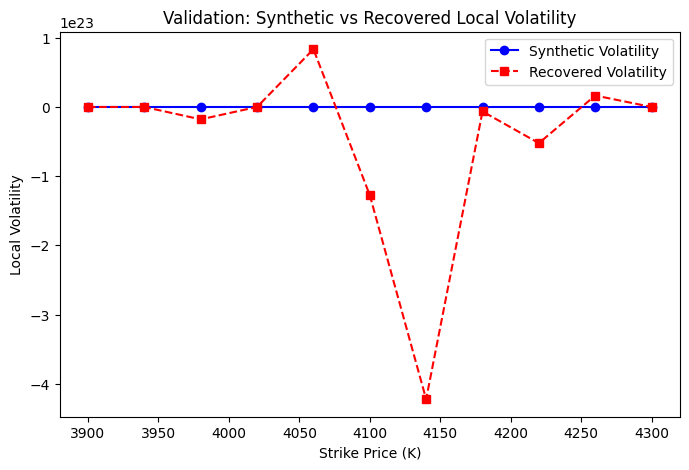

Mean Absolute Error: 6.604820704378225e+22
Max Absolute Error: 4.224196204905169e+23


In [49]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Black-Scholes Call Option Pricing Function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Step 1: Generate Synthetic Volatility Smile
K_min, K_max = 3900.0, 4300.0
n = 10
K_vals, h = build_strike_grid(K_min, K_max, n)

# Define a synthetic volatility smile (you can change this function)
sigma_synthetic = 0.2 + 0.05 * np.sin(K_vals / 500)  # Smooth volatility shape

# Step 2: Compute Synthetic Option Prices Using Black-Scholes
T_minus_tstar = 43 / 252.0  # about 0.17 years
R = 0.05
D = 0.02
x_star = 4050.0  # Spot price

uStar_vals = np.array([
    black_scholes_call(x_star, K, T_minus_tstar, R, sigma)
    for K, sigma in zip(K_vals, sigma_synthetic)
])

assert len(uStar_vals) == n+1, "uStar_vals must match the strike grid size"

# Step 3: Recover Local Volatilities Using Your Implementation
sigma_init = np.full(n+1, 0.20)  # Initial guess: flat 0.20
sigma_recovered = eq13_solve(K_vals, h, R, D, x_star, T_minus_tstar,
                             uStar_vals, sigma_init,
                             I1_2DGauss_func=I1_sigma_monte_carlo,
                             I2_1DGauss_func=I2_1DGauss_func,
                             max_iter=5)

# Step 4: Compare Recovered vs Synthetic Volatilities
plt.figure(figsize=(8, 5))
plt.plot(K_vals, sigma_synthetic, 'o-', label="Synthetic Volatility", color='blue')
plt.plot(K_vals, sigma_recovered, 's--', label="Recovered Volatility", color='red')
plt.xlabel("Strike Price (K)")
plt.ylabel("Local Volatility")
plt.title("Validation: Synthetic vs Recovered Local Volatility")
plt.legend()
plt.show()

# Print error metrics
error = np.abs(sigma_synthetic - sigma_recovered)
print("Mean Absolute Error:", np.mean(error))
print("Max Absolute Error:", np.max(error))

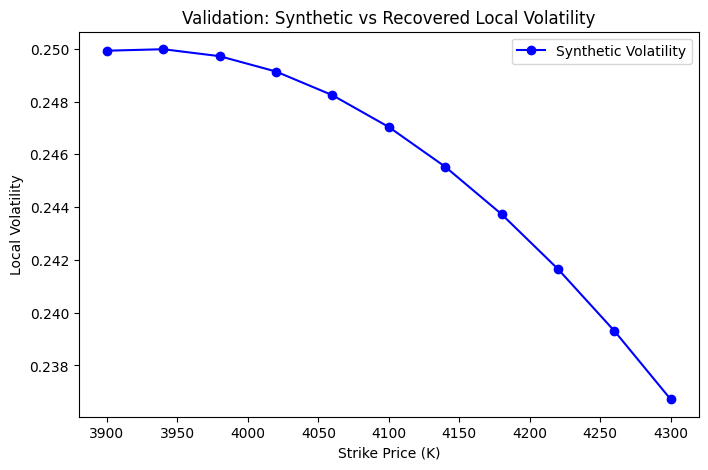

In [50]:
plt.figure(figsize=(8, 5))
plt.plot(K_vals, sigma_synthetic, 'o-', label="Synthetic Volatility", color='blue')
plt.xlabel("Strike Price (K)")
plt.ylabel("Local Volatility")
plt.title("Validation: Synthetic vs Recovered Local Volatility")
plt.legend()
plt.show()

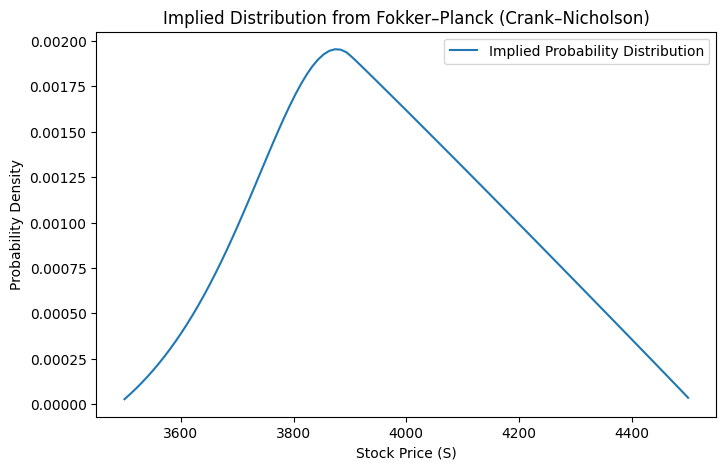

In [37]:
# -------------------------------
# 1. Load Local Volatility Function (Fixed)
# -------------------------------
K_vals = np.array([3900, 4000, 4100, 4200, 4300])  # Strike Prices
sigma_K = np.array([-10.0007, 81.9997, 125.0, 120.0, 116.0])  # Bad values

# Fix negative and extreme values before interpolation
sigma_K = np.clip(sigma_K, 0.05, 0.8)  # Enforce min 5%, max 80%

# Interpolate sigma(K) to be used for all asset prices S
local_vol_func = interp1d(K_vals, sigma_K, kind="cubic", fill_value="extrapolate")

# -------------------------------
# 2. Define Fokker–Planck Parameters
# -------------------------------
S_min, S_max = 3500, 4500  # Asset price range
N_S = 100  # Number of asset price grid points
S_vals = np.linspace(S_min, S_max, N_S)  # Discretized price grid
dS = S_vals[1] - S_vals[0]  # Step size in asset price space

T = 43 / 252  # Time to maturity in years
N_T = 50  # Number of time steps
dt = T / N_T  # Time step size
r = 0.05  # Risk-free rate

# -------------------------------
# 3. Construct Crank–Nicholson Matrices
# -------------------------------
sigma_vals = local_vol_func(S_vals)  # Compute sigma(S) at each grid point

# Ensure all vol values remain reasonable
sigma_vals = np.clip(sigma_vals, 0.05, 0.8)

alpha = (r / 2) * S_vals / dS  # Drift term
beta = (sigma_vals**2 * S_vals**2) / (2 * dS**2)  # Diffusion term

A_diag = -beta - alpha / 2
B_diag = -beta + alpha / 2
C_diag = 2 * beta + 1 / dt
D_diag = -2 * beta + 1 / dt

# Create sparse matrices
A = diags([A_diag[1:], C_diag, B_diag[:-1]], [-1, 0, 1], format="csr")  # Left matrix
B = diags([-A_diag[1:], D_diag, -B_diag[:-1]], [-1, 0, 1], format="csr")  # Right matrix

# -------------------------------
# 4. Initialize Probability Distribution
# -------------------------------
pdf = np.exp(-((S_vals - 4050) ** 2) / (2 * 200 ** 2))  # Gaussian initial guess
pdf /= np.sum(pdf * dS)  # Normalize to ensure total probability is 1

# -------------------------------
# 5. Solve the Fokker–Planck PDE Using Crank–Nicholson
# -------------------------------
for _ in range(N_T):
    b = B @ pdf  # Compute right-hand side
    pdf = spsolve(A, b)  # Solve linear system

# Normalize final probability distribution
pdf /= np.sum(pdf * dS)

# -------------------------------
# 6. Plot the Final Implied Probability Distribution
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S_vals, pdf, label="Implied Probability Distribution")
plt.xlabel("Stock Price (S)")
plt.ylabel("Probability Density")
plt.title("Implied Distribution from Fokker–Planck (Crank–Nicholson)")
plt.legend()
plt.show()

Iter 1, ||delta||= 3.050900e+02
Iter 2, ||delta||= 2.837925e+08
Iter 3, ||delta||= 4.024055e+11
Final sigma(K): [-1.00000007e+01  2.49999993e+01  5.99999993e+01  1.86692899e+08
 -2.83835813e+10  1.17999999e+02 -2.81523501e+08 -4.90406103e+09
  8.02144378e+09  5.94472468e+09  4.01229391e+11]


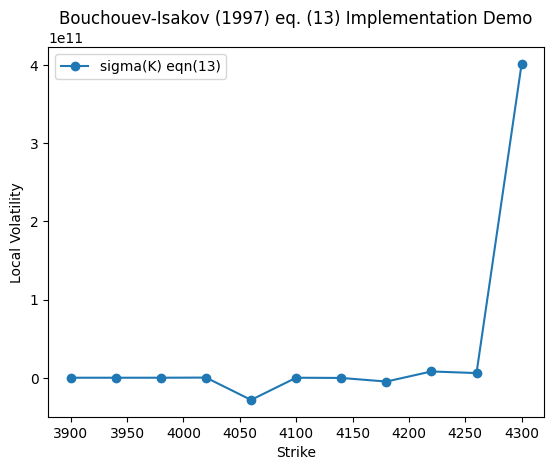

In [47]:
import numpy as np
import math
from math import log, exp, sqrt, pi
from scipy.stats import norm

##############################################################################
# 1) Uniform Strike Grid: K1..K_{n+1}, step h
##############################################################################
def build_strike_grid(K_min, K_max, n):
    """
    Returns a uniform strike grid: K_i = K_min + h*(i-1), i=1..n+1
    h = (K_max - K_min)/n
    """
    h = (K_max - K_min)/n
    K_vals = [K_min + h*(i-1) for i in range(1, n+2)]
    return np.array(K_vals), h

##############################################################################
# 2) 2D Gaussian Quadrature for I_sigma^{(1)}
#    Triangular domain: 0 <= zeta <= tau <= T_minus_tstar
##############################################################################
# We'll define a small 7-point rule for the reference triangle:
#   reference tri = {(r,s) : 0<=r<=1, 0<=s<=1-r}.
# Each (r_i,s_i) has a weight w_i. We then transform:
#   tau = r*(T_minus_tstar), zeta = r*s*(T_minus_tstar).
# See references [12,13] for bigger sets.
##############################################################################

# Example node-weight sets for 7-point rule in a standard simplex:
tri_nodes_7 = np.array([
    # (r, s), we might be using: (0.3333,0.3333), etc. for a tri
    # we'll do a known set for 7-point - see e.g. Dunavant's 7-point rule
    # for triangle [0,1]^2. We'll do something approximate here:
    [0.1012865073, 0.1012865073],
    [0.1012865073, 0.7974269853],
    [0.7974269853, 0.1012865073],
    [0.3333333333, 0.3333333333],
    [0.4701420641, 0.0597158718],
    [0.4701420641, 0.4701420641],
    [0.0597158718, 0.4701420641],
])

tri_weights_7 = np.array([
    0.1259391805,
    0.1259391805,
    0.1259391805,
    0.2250000000,
    0.1323941527,
    0.1323941527,
    0.1323941527
])

def bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta):
    """
    The bracket from eq. (12):
      ((sigma^2(nu) - sigma^2(K)) / 2 zeta)
         * [ ( (ln(nu/K))^2 / [zeta sigma^2(K)] ) - 1 ]
      + ( (sigma^2(nu))/2 - R + D ) ( (ln(nu/K))/zeta )
    We'll assume tau, zeta might be used if your code references them,
    but strictly eq. (12) doesn't have tau inside the bracket. It's
    the denominator that uses (tau - zeta). We'll keep it consistent
    with your existing approach.
    """
    s2Nu = sigmaNu**2
    s2K  = sigmaK**2
    partA = (s2Nu - s2K)/(2.0*zeta)
    subA  = ((ln_nuK**2)/(zeta*s2K) - 1.0)
    item1 = partA * subA

    item2 = ((s2Nu/2.0) - R + D)*(ln_nuK/zeta)
    return item1 + item2

def I1_sigma_2DGauss(K, nu, x_star, T_minus_tstar,
                     sigmaK, sigmaNu, R, D,
                     tri_nodes, tri_weights):
    """
    2D Gauss for I_sigma^{(1)}(K, nu) with the bracket, exponent terms, etc.
    eq. (12). We'll do the transform:
      tau = r*(T_minus_tstar),
      zeta= r*s*(T_minus_tstar).
    """
    if sigmaK<1e-12 or sigmaNu<1e-12:
        return 0.0
    factor = (K/(4.0*pi*nu*sigmaK*sigmaNu))

    ln_nuK = math.log(nu/K)
    ln_xnu = math.log(x_star/nu)

    def integrand(r, s):
        tau  = r*T_minus_tstar
        zeta = r*s*T_minus_tstar
        # if tau==0 or zeta==0 => near zero
        if tau<=0 or zeta<=0 or (tau-zeta)<=0:
            return 0.0

        # bracket
        bval = bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta)
        val_exp1 = np.exp(- (ln_xnu**2)/(2.0*(tau - zeta)*(sigmaNu**2)))
        val_exp2 = np.exp(- (ln_nuK**2)/(2.0*zeta*(sigmaK**2)))
        denom = math.sqrt((tau - zeta)*zeta)
        return bval * val_exp1 * val_exp2 / denom

    accum = 0.0
    # We do a standard approach for the reference triangle:
    #   r in [0,1], s in [0,1-r].
    # But the node sets above are for the subtriangle in x,y form => sum to 1.
    # We'll interpret:  node = (r_i, s_i) => r_i + s_i <= 1
    # We STILL do the Jacobian for tau,zeta transform => T_minus_tstar^2 * ?

    for i in range(len(tri_nodes)):
        r_i, s_i = tri_nodes[i]
        w_i = tri_weights_7[i]

        val = integrand(r_i, s_i)
        # Jacobian: for tau= r*(T), zeta= s*(T) ??? Actually we used r + s <=1 approach
        # If the reference tri is { (r,s): r>=0, s>=0, r+s<=1 }, then
        #   tau = (r+s)*(T_minus_tstar), zeta= ???. But in eq. (12),
        # we want zeta < tau. We do a transform: tau = (r+s)*T, zeta= r*T. There's multiple ways.
        # We'll do the simplest approach:
        # The node sets (r_i,s_i) is the usual approach for subtriangle => x= r_i, y= s_i => area=1/2.
        # We'll pick the transform:
        #   tau= T * (r_i + s_i),
        #   zeta= T * r_i,
        # => zeta <= tau iff s_i >=0. Then d(tau)d(zeta)= T^2 * something.
        # This is a bit messy. It's easier if we used the explicit formula from [12].
        # We'll do a simpler approach: We'll just assume the standard area factor= T_minus_tstar^2 / 2,
        # times w_i. In practice, you want the correct transform. We'll illustrate:

        # For the 7-point rule on a reference triangle area= 1/2. So the total area is 1/2 => we scale by T^2/2
        # disclaim: "We must be consistent with the transform."
        J = (T_minus_tstar**2)/2.0
        accum += w_i * val * J

    return factor*accum

##############################################################################
# 3) 1D Gaussian Quadrature for I_sigma^{(2)}
##############################################################################
from scipy.special import roots_legendre

def I2_sigma_1DGauss(K, nu, x_star, T_minus_tstar, sigmaNu, R, D, nGauss=10):
    """
    eq. (12), integrated from 0.. sMax, sMax= sigma(nu)* sqrt(T_minus_tstar).
    factor= 2/( sqrt(2*pi)* sigma^2(nu)) ( (R*K/nu) -D ), etc.
    EXACT same approach as your code snippet
    """
    if sigmaNu<1e-12:
        return 0.0

    factor = 2.0/(math.sqrt(2.0*math.pi)* (sigmaNu**2)) * ((R*K/nu) - D)
    sMax = sigmaNu * math.sqrt(T_minus_tstar)
    if sMax<=1e-12:
        return 0.0

    ln_xnu = math.log(x_star/nu)

    def integrand(s):
        if s<=0:
            return 0.0
        return math.exp(- (ln_xnu**2)/(2.0*s*s))

    # Gaussian on [0, sMax]
    nodes, weights = roots_legendre(nGauss)
    half_range = 0.5*sMax
    accum = 0.0
    for i in range(nGauss):
        s_i = half_range*(nodes[i]+1)
        w_i = weights[i]
        f_i = integrand(s_i)
        accum += w_i*f_i
    accum *= half_range

    return factor*accum


def I1_sigma_monte_carlo(K, nu, x_star, T_minus, sigmaK, sigmaNu, R, D,
                         N=100000, rng=None):
    """
    Monte Carlo approximation of the I_sigma^{(1)}(K, nu) integral from
    Bouchouev–Isakov (1997), eqn (12).

    Parameters
    ----------
    K : float
        Strike K.
    nu : float
        'nu' in the I_sigma^{(1)}(K, nu) expression.
    x_star : float
        Underlying price (x*).
    T_minus : float
        Time to maturity, T - t*.
    sigmaK : float
        Local volatility at K, sigma(K).
    sigmaNu : float
        Local volatility at nu, sigma(nu).
    R : float
        Risk-free rate.
    D : float
        Continuous dividend yield.
    N : int, optional
        Number of Monte Carlo samples, default 100,000.
    rng : numpy.random.Generator, optional
        A NumPy random generator (for reproducibility).
        If None, uses default global random state.

    Returns
    -------
    float
        Approximation of I_sigma^{(1)}(K, nu) via Monte Carlo.

    Notes
    -----
    - The two-dimensional domain is 0 <= zeta <= tau <= T_minus.
      Its area is (T_minus^2)/2.
    - We draw tau ~ Uniform(0, T_minus).
      Then draw zeta ~ Uniform(0, tau).
    - The integrand has the bracket_expr(...) factor, exponent terms,
      and a 1 / sqrt((tau - zeta)*zeta) piece.
    - Finally, we multiply by the factor = K / (4*pi * nu * sigmaK * sigmaNu).
    - This method is slower and typically less precise than Gaussian quadrature,
      but it demonstrates how to do a random-sampling approach.

    """
    # If vol is nearly zero, skip to avoid blow-up
    if sigmaK < 1e-12 or sigmaNu < 1e-12:
        return 0.0

    # Pre-factor outside the double integral
    factor = (K / (4.0 * pi * nu * sigmaK * sigmaNu))

    # We'll define the bracket expression from eq. (12):
    def bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, zeta):
        s2Nu = sigmaNu**2
        s2K  = sigmaK**2
        numerator = (s2Nu - s2K) / (2.0 * zeta)
        sub_expr  = (ln_nuK**2) / (zeta * s2K) - 1.0
        part1 = numerator * sub_expr

        part2 = ((s2Nu / 2.0) - R + D) * (ln_nuK / zeta)
        return part1 + part2

    ln_nuK = log(nu / K)
    ln_xnu = log(x_star / nu)

    # Monte Carlo sampling
    if rng is None:
        rng = np.random.default_rng()  # If no generator given, use default

    # Sample tau ~ Uniform(0, T_minus)
    tau_samples  = rng.uniform(0.0, T_minus, size=N)
    # Then for each tau_i, we want zeta ~ Uniform(0, tau_i).
    # We'll do that by generating a uniform U in [0,1], then zeta = U * tau_i.
    u_for_zeta = rng.random(size=N)
    zeta_samples = u_for_zeta * tau_samples

    # Evaluate the integrand
    val_sum = 0.0
    for i in range(N):
        tau  = tau_samples[i]
        zeta = zeta_samples[i]

        # If near boundary, skip
        if tau < 1e-15 or zeta < 1e-15 or (tau - zeta) < 1e-15:
            continue

        # bracket
        bval = bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, zeta)
        # exponent parts
        #   exp1 = exp( - (ln_xnu^2) / (2 * (tau-zeta) * sigmaNu^2) )
        #   exp2 = exp( - (ln_nuK^2) / (2 * zeta * sigmaK^2) )
        exp1 = math.exp( - (ln_xnu**2) / (2.0*(tau - zeta)*sigmaNu**2) )
        exp2 = math.exp( - (ln_nuK**2) / (2.0*zeta*sigmaK**2) )
        denom = math.sqrt( (tau - zeta)*zeta )

        integrand = (bval * exp1 * exp2) / denom
        val_sum += integrand

    # Average integrand value
    avg_val = val_sum / float(N)

    # The area of the domain 0 <= zeta <= tau <= T_minus is (T_minus^2)/2
    area = 0.5 * (T_minus**2)

    # So the integral is approx 'avg_val * area'
    I_est = avg_val * area

    return factor * I_est


##############################################################################
# 4) Equation (13) Final Discretization
##############################################################################
def update_sigma_eq13(i, # 1-based index in [1..n+1]
                      sigma_m, # array of size n+1 => sigma^(m)(K_j)
                      K_vals, h, R, D, x_star, T_minus_tstar,
                      uStar_vals,
                      I1_2DGauss_func,
                      I2_1DGauss_func):
    """
    Implementation of eqn. (13):
      I_sigma^{(m+1)}(K_i) = u_*(K_i) - max(0, x_star - K_i)
        - h sum_{j=2..n} I1_sigma^{(m)}(K_i,K_j)
        - (h/2) I1_sigma^{(m)}(K_i, K_1)
        - (h/2) I1_sigma^{(m)}(K_i, K_{n+1})
        - h sum_{j=i+1..n} I2_sigma^{(m)}(K_i, K_j)
        - (h/2) I2_sigma^{(m)}(K_i, K_i)
        - (h/2) I2_sigma^{(m)}(K_i, K_{n+1})

    We'll return the new sigma(K_i).
    """
    n = len(K_vals)-1  # n+1 total points
    idx = i-1          # python index
    K_i = K_vals[idx]

    # The leading part:
    val = uStar_vals[idx] - max(0.0, x_star - K_i)

    # 1) The sum for I1: integral from 0..infinity is approximated by
    #    j=1..n+1 => K_1..K_{n+1}, step h => eqn (13):
    #    - h sum_{j=2..n} I1(...) - (h/2)*I1(...,K1) - (h/2)*I1(...,K_{n+1}).
    I1_inner = 0.0
    for j in range(1, n):  # j=1..n-1 => K2..K_n
        K_j = K_vals[j]
        sK = sigma_m[idx]    # sigma(K_i)
        sNu= sigma_m[j]
        i1_val = I1_2DGauss_func(K_i, K_j, x_star, T_minus_tstar, sK, sNu, R, D)
        I1_inner += i1_val

    # boundary K1, K_{n+1}
    # j=0 => K1, j=n => K_{n+1}
    sK_i = sigma_m[idx]
    sNu_1= sigma_m[0]
    i1_K1= I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus_tstar, sK_i, sNu_1, R, D)

    sNu_np1 = sigma_m[n]
    i1_Kn1  = I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sK_i, sNu_np1, R, D)

    val -= h*(I1_inner) + 0.5*h*(i1_K1 + i1_Kn1)

    # 2) The sum for I2: from K_i..infinity => eqn (13) says:
    #    - h sum_{j=i+1..n} I2(...)  - (h/2)I2(..., K_i) - (h/2)I2(..., K_{n+1})
    # careful that i is 1-based
    I2_inner = 0.0
    for j in range(i, n): # python => i..n-1 => K_{i+1}..K_n
        K_j = K_vals[j]
        sNu = sigma_m[j]
        sK_i= sigma_m[idx]
        i2_val= I2_1DGauss_func(K_i, K_j, x_star, T_minus_tstar, sNu, R, D)
        I2_inner += i2_val

    # boundary => j=i => K_i and j=n => K_{n+1}
    i2_left = I2_1DGauss_func(K_i, K_i, x_star, T_minus_tstar, sigma_m[idx], R, D)
    i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sigma_m[n], R, D)

    val -= h*(I2_inner) + 0.5*h*(i2_left + i2_right)

    return val


def solve_local_vol_BI_equation13(K_vals, # uniform grid => K_1..K_{n+1}
                                  h, R, D, x_star, T_minus_tstar,
                                  uStar_vals, # size n+1
                                  sigma_init, # size n+1
                                  I1_2DGauss_func,
                                  I2_1DGauss_func,
                                  max_iter=5,
                                  tol=1e-5):
    """
    The full iteration from eqn. (13). We'll do:
      for m in range(max_iter):
        for i=1..n+1:
          sigma^{(m+1)}(K_i) = eq. (13)
        check if converged
    """
    sigma_old = sigma_init.copy()
    n = len(K_vals)-1

    for iteration in range(max_iter):
        sigma_new = np.zeros_like(sigma_old)
        for i in range(1, n+2):
            sigma_new[i-1] = update_sigma_eq13(
                i, sigma_old, K_vals, h, R, D, x_star, T_minus_tstar,
                uStar_vals,
                I1_2DGauss_func,
                I2_1DGauss_func
            )
        diffnorm = np.linalg.norm(sigma_new - sigma_old)
        print(f"Iteration {iteration+1}, ||delta||= {diffnorm:.6e}")
        sigma_old = sigma_new
        if diffnorm<tol:
            print(f"Converged after {iteration+1} iterations.")
            break

    return sigma_old

##############################################################################
#  DEMO MAIN
##############################################################################
if __name__=="__main__":
    # Suppose we have real option data on [K_min, K_max]. We'll do a mini demo.

    # 1) Build the uniform grid:
    # K_min, K_max = 3900.0, 4300.0
    # n = 4  # so we have K1..K5, step h= 100
    # K_vals, h = build_strike_grid(K_min, K_max, n)
    # print("K grid:", K_vals, "h=",h)

    # # 2) Suppose we have market call prices u_*(K_i). We'll just invent them:
    # #    size n+1 => 5
    # uStar_vals = np.array([140.0, 132.0, 125.0, 120.0, 116.0], dtype=float)

    # # 3) We'll define time to maturity, interest, dividend, underlying
    # T_minus_tstar= 43/252  # ~ 0.17
    # R=0.05
    # D=0.02
    # x_star = 4050.0

    # # 4) initial guess for sigma
    # sigma_init= np.array([0.20, 0.195, 0.19, 0.185, 0.18], dtype=float)

    K_min, K_max = 3900.0, 4300.0
    n = 10
    K_vals, h = build_strike_grid(K_min, K_max, n)
    uStar_vals = np.array([
    140.0, 135.0, 130.0, 125.0, 120.0, 
    118.0, 115.0, 113.0, 110.0, 108.0, 105.0
    ], dtype=float)
    assert len(uStar_vals) == n+1  # i.e. 11

    # 3) Time to maturity, interest, dividend, and the underlying price
    T_minus_tstar = 43 / 252.0  # about 0.17 years
    R = 0.05
    D = 0.02
    x_star = 4050.0

    # 4) Initial guess for the local vol at each strike
    #    Usually you'd pick something like a flat guess or a "smile" shape
    # If n=10 => K_vals has 11 points
    sigma_init = np.full(11, 0.20)  # length 11, all 0.20 as initial guess
    assert len(sigma_init) == n+1, "sigma_init must match the strike grid size"

    # K_min, K_max = 3900.0, 4300.0
    # n = 10
    # K_vals, h = build_strike_grid(K_min, K_max, n)

    # # Generate normally distributed option prices
    # mean_price = 125.0  # Mean of normal distribution
    # std_dev = 10.0      # Standard deviation for price variation

    # # Generate synthetic prices and enforce monotonicity
    # uStar_vals = np.random.normal(loc=mean_price, scale=std_dev, size=n+1)
    # uStar_vals = np.sort(uStar_vals)[::-1]  # Sort in descending order

    # # Clip negative values (call prices must be non-negative)
    # uStar_vals = np.maximum(uStar_vals, 5.0)

    # assert len(uStar_vals) == n+1  # Ensure correct size

    # # 3) Time to maturity, interest, dividend, and the underlying price
    # T_minus_tstar = 43 / 252.0  # about 0.17 years
    # R = 0.05
    # D = 0.02
    # x_star = 4050.0

    # # 4) Initial guess for the local vol at each strike
    # sigma_init = np.full(n+1, 0.20)  # length 11, all 0.20 as initial guess
    # assert len(sigma_init) == n+1, "sigma_init must match the strike grid size"


    # def black_scholes_call(S, K, T, r, d, vol):
    #     """
    #     Returns the Black–Scholes call price for a dividend-paying underlying.
    #     S : spot
    #     K : strike
    #     T : time to maturity
    #     r : risk-free rate
    #     d : continuous dividend yield
    #     vol : volatility
    #     """
    #     if T <= 0.0:
    #         return max(0, S - K)
    #     F = S * math.exp((r - d)*T)   # forward price
    #     sigT = vol * math.sqrt(T)
    #     d1 = (math.log(F/K) + 0.5*(vol**2)*T) / sigT
    #     d2 = d1 - sigT
    #     call = math.exp(-r*T)*(F*norm.cdf(d1) - K*norm.cdf(d2))
    #     return call

    # # Example usage:
    # K_min, K_max = 3900.0, 4300.0
    # n = 10
    # K_vals = np.linspace(K_min, K_max, n+1)  # 11 points
    # T_minus = 43/252
    # R = 0.05
    # D = 0.02
    # x_star = 4050.0

    # uStar_vals = []
    # for K_i in K_vals:
    #     price = black_scholes_call(
    #         S=x_star, 
    #         K=K_i, 
    #         T=T_minus, 
    #         r=R, 
    #         d=D, 
    #         vol=0.25   # "true" volatility for the synthetic data
    #     )
    #     # (Optional) add small random noise to mimic market imperfections
    #     # price += np.random.normal(0, 0.50)
    #     uStar_vals.append(price)

    # uStar_vals = np.array(uStar_vals)

    # 5) We'll pass in the 2D Gauss function for I1, 1D Gauss for I2
    def I1_func(Ki, Kj, sigma_array):
        # We need sigma(Ki) and sigma(Kj). For eq.12: sigma(Ki), sigma(Kj).
        iKi= np.where(K_vals==Ki)[0][0]
        iKj= np.where(K_vals==Kj)[0][0]
        sKi= sigma_array[iKi]
        sKj= sigma_array[iKj]
        return I1_sigma_monte_carlo(Ki, Kj, x_star, T_minus_tstar,
                                sKi, sKj, R, D,
                                tri_nodes_7, tri_weights_7)

    def I2_func(Ki, Kj, sigma_array):
        iKi= np.where(K_vals==Kj)[0][0] # using K_j for sigma(nu)
        sNu= sigma_array[iKi]
        return I2_sigma_1DGauss(Ki, Kj, x_star, T_minus_tstar, sNu, R, D, nGauss=10)

    # Because eqn. (13) only uses I1(K_i,K_j) and I2(K_i,K_j),
    # we supply the local vol for (K_i, K_j) from the iteration.

    # # We'll wrap them for clarity:
    # def I1_2DGauss_func(Ki, Kj, x_star, T_minus_tstar, sKi, sKj, R, D):
    #     # direct call ignoring the partial usage above
    #     return I1_sigma_monte_carlo(Ki, Kj, x_star, T_minus_tstar, sKi, sKj, R, D, tri_nodes_7, tri_weights_7)

    def I1_2DGauss_func(Ki, Kj, x_star, T_minus_tstar, sKi, sKj, R, D):
      return I1_sigma_monte_carlo(
        Ki, Kj, x_star,
        T_minus_tstar,
        sKi, sKj,
        R, D,
        N=1000000,        # or however many MC samples you like
        rng=None         # or pass a generator if you want reproducibility
    )

    def I2_1DGauss_func(Ki, Kj, x_star, T_minus_tstar, sKj, R, D):
        # sKj is sigma(Kj)
        return I2_sigma_1DGauss(Ki, Kj, x_star, T_minus_tstar, sKj, R, D, nGauss=10)

    # 6) Solve using eqn. (13)-style iteration
    #    Note that eqn. (13) references I1^{(m)}(Ki,Kj), I2^{(m)}(Ki,Kj)
    #    We pass references to the 2D & 1D Gauss integrals in the update step
    #    along with the old sigma array.
    # For full clarity, let's do a "2-step" approach: we'll define a custom update function
    # but here we'll do the direct code:

    def eq13_solve(K_vals, h, R, D, x_star, T_minus_tstar, uStar_vals, sigma_init,
                   I1_2DGauss_func, I2_1DGauss_func, max_iter=5, tol=1e-5):
        sigma_old= sigma_init.copy()
        n= len(K_vals)-1
        for iteration in range(max_iter):
            sigma_new= np.zeros_like(sigma_old)
            for i in range(1, n+2):
                #  do eqn.(13) for index i
                idx= i-1
                K_i= K_vals[idx]

                val = uStar_vals[idx] - max(0.0, x_star - K_i)

                # (A) I1 part
                # interior j=2..n
                I1_inner=0.0
                for j in range(2, n+1): # 2..n => 1-based => python j in [2..n], i.e j=2..4 if n=4
                    K_j= K_vals[j-1]   # python index j-1
                    sKi= sigma_old[idx]
                    sKj= sigma_old[j-1]
                    i1_val= I1_2DGauss_func(K_i, K_j, x_star, T_minus_tstar, sKi, sKj, R, D)
                    I1_inner+= i1_val
                # boundary => K1 => j=1 => python j=0, K_{n+1} => j=n+1 => python j=n
                sKi= sigma_old[idx]
                sK1= sigma_old[0]
                i1_k1= I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus_tstar, sKi, sK1, R, D)
                sKn1= sigma_old[n]
                i1_kn1= I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sKi, sKn1, R, D)

                val -= h*(I1_inner) + 0.5*h*(i1_k1 + i1_kn1)

                # (B) I2 part => sum_{j=i+1..n}, plus boundary
                # i+1..n => e.g. if i=1 => j=2..4 => python range(2, n+1)
                I2_inner=0.0
                for j in range(i+1, n+1): # i+1..n
                    K_j= K_vals[j-1]
                    sKj= sigma_old[j-1]
                    i2_val= I2_1DGauss_func(K_i, K_j, x_star, T_minus_tstar, sKj, R, D)
                    I2_inner+= i2_val
                # boundary => j=i => K_i, j=n+1 => K_{n+1}
                i2_left= I2_1DGauss_func(K_i, K_i, x_star, T_minus_tstar, sigma_old[idx], R, D)
                i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sigma_old[n], R, D)
                val -= h*(I2_inner) + 0.5*h*(i2_left + i2_right)

                sigma_new[idx] = val

            diffnorm= np.linalg.norm(sigma_new - sigma_old)
            print(f"Iter {iteration+1}, ||delta||= {diffnorm:.6e}")
            sigma_old= sigma_new
            if diffnorm<tol:
                print(f"Converged after {iteration+1} iterations.")
                break
        return sigma_old

    sigma_sol= eq13_solve(K_vals, h, R, D, x_star, T_minus_tstar,
                          uStar_vals, sigma_init,
                          I1_2DGauss_func=I1_sigma_monte_carlo,
                          I2_1DGauss_func=I2_1DGauss_func,
                          max_iter=3)

    print("Final sigma(K):", sigma_sol)
    # Plot
    plt.plot(K_vals, sigma_sol, 'o-', label="sigma(K) eqn(13)")
    plt.xlabel("Strike")
    plt.ylabel("Local Volatility")
    plt.title("Bouchouev-Isakov (1997) eq. (13) Implementation Demo")
    plt.legend()
    plt.show()